# Feature exploration and comparison to Brier Score


## Set up

Set up the code

In [3]:
# Set up to use local modules
%load_ext autoreload
%autoreload 2
import os
import sys
module_path = os.path.abspath(os.path.join('..')) # Add parent directory to path
sys.path.insert(0, module_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# Imports
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import matplotlib.ticker as ticker
import matplotlib.patches as mpatches
import numpy as np
import pandas as pd
from scipy.stats import beta
from scipy.stats import linregress
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import wordninja
import xgboost as xgb

# Local imports
from src import process
from src import plot
from src import util

data_path = process.DEFAULT_DATA_PATH

In [5]:
# Load data
blind_mode_df, estimates_df = process.load_and_process_results(
    fix_bad_rows=True, remove_bad_rows=True
)
# pd.set_option("display.max_columns", None)
blind_mode_df.head()

,Whichmodeareyouplayingin,ForecastingExperience,Superforecaster,LessWrong,@1.WillVladimirPutinbePresidentofRussia,@2.WillUkrainecontrolthecityofSevastopol,@3.WillUkrainecontrolthecityofLuhansk,@4.WillUkrainecontrolthecityofZaporizhzhia,@5.WilltherebealastingceasefireintheRussiaUkrainewar,@6.WilltheKerchBridgebedestroyedsuchthatnovehiclecanpassoverit,...,Wouldyouquotwireheadquotifyouhadtheoption,Howmuchdoyoutrustthemainstreammedia,Ifyouanswered1or2mostlydistrustonthequestionabovewhichoftheseeve,OptionalWasthereanyotherspecificarticleoreventthatseriouslyunder,Howgoodasenseofdirectionorientationandnavigationdoyouhave,Howmuchdoflashingorchangingelementsdetractfromyourenjoymentofweb,Howmanybrowsertabsdoyouhaveopenrightnow,Howmanyunreademailsareinyourinboxrightnow,SupposeItoldyouthatyourfirstguessabouthowthedistancebetweenParis,Ifyouaposvetriedpsychotherapyforanyissuehowwelldiditwork
0,Blind Mode (recommended),No,No,No,99.0,1.0,1.0,1.0,99.0,1.0,...,1.0,1.0,"COVID (later support for vaccines, masks, lock...",None,1.0,I notice these and they annoy me a little,10 - 50,1651,2000.0,5.0
1,Blind Mode (recommended),No,No,No,99.0,1.0,50.0,50.0,85.0,15.0,...,2.0,1.0,"COVID (later support for vaccines, masks, lock...",all of the above plus a constant blizzard of o...,4.0,I notice them and they annoy me so much that I...,More than 50,0,1850.0,NaN
2,Blind Mode (recommended),No,No,No,99.0,1.0,50.0,33.0,1.0,20.0,...,1.0,4.0,None,None,2.0,I notice these and they annoy me a little,2-5,1,8000.0,NaN
3,Blind Mode (recommended),No,No,No,99.0,1.0,1.0,1.0,50.0,10.0,...,1.0,1.0,Attempt to link Trump to Russia,Effective cancelling of Simon Bridges,4.0,I notice them and they annoy me quite a bit,10 - 50,2,3000.0,NaN
4,Blind Mode (recommended),No,No,No,99.0,30.0,30.0,75.0,40.0,80.0,...,4.0,4.0,None,None,4.0,I notice them and they annoy me quite a bit,5 - 10,0,2000.0,NaN


In [6]:
# Print all columns and the number of unique values in each
use_formated_column_names = False
for col in blind_mode_df.columns:
    if use_formated_column_names:
        formated_column_name = (" ").join(wordninja.split(col))
    else:
        formated_column_name = col
    print(f"{formated_column_name}: {blind_mode_df[col].nunique()}")

Whichmodeareyouplayingin: 1
ForecastingExperience: 2
Superforecaster: 2
LessWrong: 2
@1.WillVladimirPutinbePresidentofRussia: 71
@2.WillUkrainecontrolthecityofSevastopol: 91
@3.WillUkrainecontrolthecityofLuhansk: 93
@4.WillUkrainecontrolthecityofZaporizhzhia: 90
@5.WilltherebealastingceasefireintheRussiaUkrainewar: 94
@6.WilltheKerchBridgebedestroyedsuchthatnovehiclecanpassoverit: 83
@7.WillanissueinvolvinganuclearpowerplantinUkrainerequireevacuat: 84
@8.Willanuclearweaponbedetonatedincludingtestsandaccidents: 86
@9.Willanuclearweaponbeusedinwarienotatestoraccidentandkillatlea: 55
@10.WillChinalaunchafullscaleinvasionofTaiwan: 67
@11.WillanynewcountryjoinNATO: 89
@12.WillAliKhameiniceasetobeSupremeLeaderofIran: 95
@13.WillanyotherwarhavemorecasualtiesthanRussiaUkraine: 73
@14.Willtherebemorethan25millionconfirmedCOVIDcasesinChina: 92
@15.WillpredictionmarketssayJoeBidenisthemostlikelyDemocraticnom: 95
@16.WillpredictionmarketssayGavinNewsomisthemostlikelyDemocratic: 76
@17.Willpredicti

In [7]:
blind_mode_feature_df = process.get_feature_df(blind_mode_df)
blind_mode_feature_df.head()

,Age,Children,IQ,SATscoreverbalreading,SATscoremath,PoliticalSpectrum,PoliticalInterest,GlobalWarming,Immigration,MinimumWage,...,Monogomous,USA,Heterosexual,Consequentialist,Vegetarian,LeftHanded,Burp,OwnCrypto,PoliticalAffiliation,PoliticalMovement
0,68.0,2.0,NaN,740.0,690.0,8.0,4.0,5.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0,0.0,3.0,0,1.0,0.0
1,66.0,0.0,NaN,NaN,NaN,5.0,1.0,4.0,3.0,3.0,...,1.0,0.0,1.0,0.0,0,0.0,3.0,0,NaN,0.0
2,62.0,2.0,NaN,720.0,630.0,6.0,5.0,3.0,4.0,2.0,...,1.0,1.0,1.0,0.0,0,0.0,1.0,0,0.0,0.0
3,51.0,0.0,NaN,NaN,NaN,5.0,3.0,5.0,1.0,3.0,...,1.0,0.0,1.0,0.0,0,0.0,1.0,0,1.0,0.0
4,50.0,0.0,NaN,700.0,420.0,4.0,3.0,2.0,4.0,3.0,...,1.0,1.0,1.0,0.0,0,0.0,3.0,0,-1.0,0.0


In [8]:
# pd.set_option("display.max_columns", None)
blind_mode_feature_df.select_dtypes(float).describe()

,Age,Children,IQ,SATscoreverbalreading,SATscoremath,PoliticalSpectrum,PoliticalInterest,GlobalWarming,Immigration,MinimumWage,...,Male,Atheist,Monogomous,USA,Heterosexual,Consequentialist,LeftHanded,Burp,PoliticalAffiliation,PoliticalMovement
count,1067.000000,1063.000000,260.000000,389.000000,401.000000,1060.000000,1068.000000,1068.000000,1063.000000,1051.000000,...,1069.000000,1068.000000,1067.000000,1069.000000,1069.000000,1056.000000,1048.000000,1054.000000,1048.000000,1064.000000
mean,35.307873,0.722954,136.076923,749.498715,748.566085,4.646226,3.609551,2.115169,3.699906,3.005709,...,0.949486,0.624532,0.772259,0.560337,0.883068,0.442235,0.113550,1.840607,-0.543893,0.065789
std,10.607712,1.196220,12.380777,55.619178,58.890799,1.863707,0.992088,1.115132,1.230983,1.205529,...,0.219107,0.484470,0.419571,0.496578,0.321489,0.496887,0.317415,1.038308,0.714150,0.576585
min,14.000000,0.000000,97.000000,460.000000,420.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.000000,-1.000000
25%,28.000000,0.000000,129.750000,720.000000,720.000000,3.000000,3.000000,1.000000,3.000000,2.000000,...,1.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,1.000000,-1.000000,0.000000
50%,33.000000,0.000000,135.500000,760.000000,770.000000,4.000000,4.000000,2.000000,4.000000,3.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,2.000000,-1.000000,0.000000
75%,40.000000,1.000000,144.000000,800.000000,800.000000,6.000000,4.000000,3.000000,5.000000,4.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,3.000000,0.000000,0.000000
max,77.000000,9.000000,178.000000,800.000000,800.000000,10.000000,5.000000,5.000000,5.000000,5.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,1.000000


In [9]:
# Load the market data from process.get_all_markets()
markets_df = process.get_current_probs()
markets_df.head()

Loading current probabilities from file


,question_number,question,probability,resolution
0,1,1. Will Vladimir Putin be President of Russia ...,0.989370,YES
1,2,2. Will Ukraine control the city of Sevastopol...,0.018155,NO
2,3,3. Will Ukraine control the city of Luhansk at...,0.017607,NO
3,4,4. Will Ukraine control the city of Zaporizhzh...,0.978601,YES
4,5,5. Will there be a lasting cease-fire in the R...,0.014151,NO


In [10]:
resolution_vector = process.get_target_df(df_format=False)
resolution_vector, np.mean(resolution_vector)

(array([1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0,
        1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
        0, 0, 1, 0, 0, 1]),
 0.34)

In [11]:
# resolution_vector is a list of 1s and 0s, where 1 means the actual outcome was true
# estimates_df is a dataframe of all participants estimates
# We want to find the number of participants who guessed the correct outcome
# for each question, defined as their estimate being on the correct side of 50%
# of the actual outcome
# Then print the questions, sorted by fraction that guessed correctly

# Get the number of participants who guessed the correct outcome for each question
best_guess_df = np.round(estimates_df / 100)
correct_guesses = np.sum(np.equal(best_guess_df, resolution_vector), axis=0)
attempted_count = np.sum(np.logical_not(np.isnan(estimates_df)), axis=0)
fraction_correct = correct_guesses / attempted_count
# Get the indices of the questions sorted by fraction correct
sorted_indices = np.argsort(fraction_correct)
fraction_correct[sorted_indices]

@35.WillBitcoinend2023above$30000                                   0.128853
@17.WillpredictionmarketssayDonaldTrumpisthemostlikelyRepublican    0.245747
@40.WillSpaceXapossStarshipreachorbit                               0.324761
@30.WillUSCPIinflationfor2023averageabove4                          0.325222
@23.WillDonaldTrumpgetindictedoncriminalcharges                     0.338115
@47.Willasuccessfuldeepfakeattemptcausingrealdamagemakethefrontp    0.351165
@37.WilltheUSunemploymentratenow3.7beabove4inNovember2023           0.414233
@41.WillanimagemodelwinScottAlexander’sbetoncompositionalitytoEd    0.424458
@34.WillBitcoingoupover2023                                         0.440239
@44.WillGoogleMetaAmazonorApplereleaseanARheadset                   0.447313
@14.Willtherebemorethan25millionconfirmedCOVIDcasesinChina          0.462736
@50.WillsomeonereleasequotDALLEbutforvideosquot                     0.474548
@29.WillTwitterapossaveragemonetizabledailyusersbehigherin2023th    0.508289

In [12]:
# Same as above, but sorted by distance of mean prediction from actual outcome
mean_estimate = np.array(estimates_df.mean(axis=0)) / 100
mean_distance = np.abs(mean_estimate - resolution_vector)
sorted_indices = np.argsort(mean_distance)
# Make it a series, with index as the question
fraction_correct = pd.Series(mean_distance, index=estimates_df.columns)
fraction_correct
fraction_correct.sort_values(ascending=False)

@35.WillBitcoinend2023above$30000                                   0.717180
@40.WillSpaceXapossStarshipreachorbit                               0.619170
@30.WillUSCPIinflationfor2023averageabove4                          0.617606
@17.WillpredictionmarketssayDonaldTrumpisthemostlikelyRepublican    0.605614
@23.WillDonaldTrumpgetindictedoncriminalcharges                     0.596710
@47.Willasuccessfuldeepfakeattemptcausingrealdamagemakethefrontp    0.592271
@41.WillanimagemodelwinScottAlexander’sbetoncompositionalitytoEd    0.583280
@37.WilltheUSunemploymentratenow3.7beabove4inNovember2023           0.563414
@14.Willtherebemorethan25millionconfirmedCOVIDcasesinChina          0.542623
@44.WillGoogleMetaAmazonorApplereleaseanARheadset                   0.518828
@34.WillBitcoingoupover2023                                         0.514884
@33.WilltheShanghaiindexofChinesestocksgoupover2023                 0.514327
@50.WillsomeonereleasequotDALLEbutforvideosquot                     0.511916

In [13]:
# Get the values from estimates_df and convert to a numpy array
print("Replacing nans with median of each question")
estimates_matrix = process.get_estimates_matrix(blind_mode_df)
estimates_matrix.shape

Replacing nans with median of each question


(3295, 50)

In [14]:
# Calcualte the brier score from the resolution_vector and the estimates_matrix
# resolution_vector is 50x1 for the 50 questions
# estimates_matrix is 3261x50 for the 3261 users and 50 questions

# Calculate the brier score for each participant
brier_score = np.mean(np.square(estimates_matrix - resolution_vector), axis=1)

## Data Profilers

In [15]:
run_ydata_profiling = False
use_minimal_profile = True
if run_ydata_profiling:
    from tqdm import tqdm
    from ydata_profiling import ProfileReport

    profile = ProfileReport(
        blind_mode_feature_df,
        title="Pandas Profiling Report",
        minimal=use_minimal_profile,
    )
    profile.to_notebook_iframe()

In [16]:
run_autoviz = False
if run_autoviz:
    from autoviz.AutoViz_Class import AutoViz_Class
    %matplotlib inline
    AV = AutoViz_Class()
    df_av = AV.AutoViz(data_path)

## Basic feature analysis

In [17]:
# Add brier score column to dataframes
blind_mode_feature_df["brier_score"] = brier_score
blind_mode_df["brier_score"] = brier_score

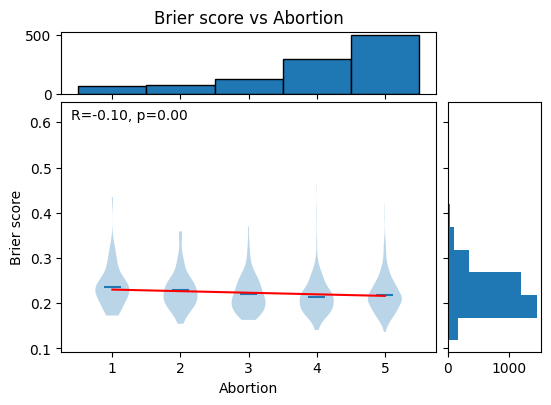

In [18]:
# Correlate brier_score with a feature

# Age, Income, ADHD, Abortion, Immigration, Male, ForecastingExperience,
feature_to_plot = "Abortion"
plot_scatter_hist = True
if plot_scatter_hist:
    fig = plot.feature_scatter_hist(blind_mode_feature_df, brier_score, feature_to_plot)
else:
    fig = plot.feature_scatter(blind_mode_feature_df, brier_score, feature_to_plot)
plt.show()

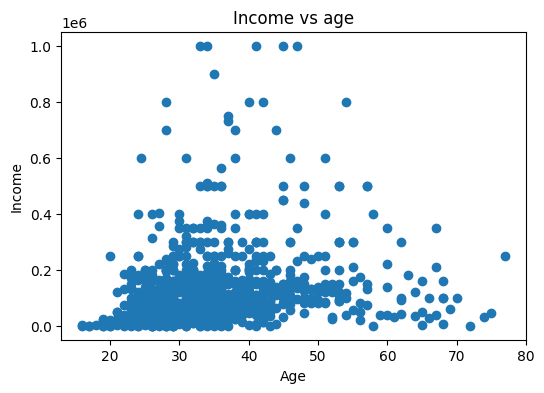

Slope: 3018.1425736753604
Intercept: 22277.096579695193
R-value: 0.21195697491975524
P-value: 8.548511748365451e-11


In [19]:
# Correlate income and age
fig = plt.figure(figsize=(6, 4))
ax = fig.add_subplot(111)
ax.scatter(blind_mode_feature_df["Age"], blind_mode_feature_df["Income"])
ax.set_title("Income vs age")
ax.set_xlabel("Age")
ax.set_ylabel("Income")
plt.show()
x = blind_mode_feature_df["Age"]
y = blind_mode_feature_df["Income"]
x = x[~np.isnan(x) & ~np.isnan(y)]
y = y[~np.isnan(y) & ~np.isnan(x)]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print("Slope:", slope)
print("Intercept:", intercept)
print("R-value:", r_value)
print("P-value:", p_value)

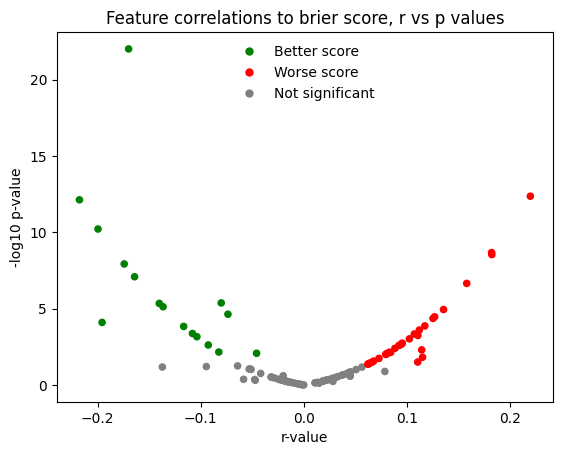

,r_value,p_value
ForecastingExperience,-0.169945,9.505081e-23
DonaldTrump,0.219501,4.267900e-13
Immigration,-0.217604,7.365457e-13
Regardlessofwhatkindofurbanenvironmentyoupersonallypreferwhatare,-0.199642,6.037774e-11
GlobalWarming,0.181911,2.124680e-09
...,...,...
ADHD,-0.004919,8.727357e-01
Income,-0.005189,8.750448e-01
RegardlessofhowyoufeelaboutitpoliticallyhowdidCOVIDlockdownaffec,-0.002072,9.462144e-01
Ifyouansweredyesabovewhatpercentoftheweighthaveyousincegainedbac,-0.001442,9.778584e-01


In [20]:
# Print the statistical significance of

# Create a list of columns to use
columns_to_use = blind_mode_feature_df.columns.tolist()
columns_to_use.remove("brier_score")
# Create a new dataframe with the columns we want to use
blind_mode_df_correlations = blind_mode_feature_df[columns_to_use]
blind_mode_df_correlations.head()

r_and_p_values = util.correlate_features_to_score(
    blind_mode_df_correlations, blind_mode_df["brier_score"]
)

fig = plot.feature_volcano_plot(r_and_p_values)
plt.show()
display(r_and_p_values.sort_values("p_value"))

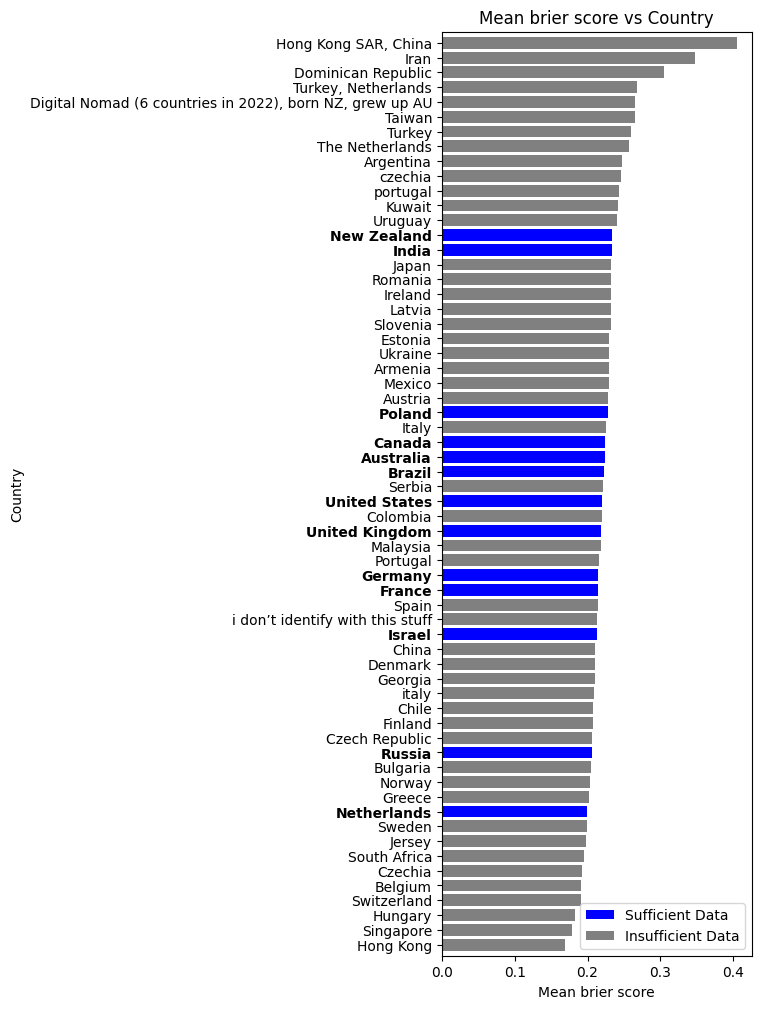

In [21]:
# Mean Brier score by country
analysis_category = "Country"  # Replace with your category
# Calculate the mean brier score for each category
mean_brier_score = blind_mode_df.groupby(analysis_category)["brier_score"].mean()
# Calculate the count of data points for each category
data_count = blind_mode_df.groupby(analysis_category).size()
# Define a threshold for too few data points
threshold = 10  # Replace with your chosen threshold
# Assign colors (grey for too few data points, blue otherwise)
bar_colors = ["grey" if count < threshold else "blue" for count in data_count]
# Sort the data by mean brier score
sorted_indices = mean_brier_score.sort_values().index
sorted_mean_brier_score = mean_brier_score.sort_values()
# Sort the bar_colors in the same order as the sorted indices
sorted_bar_colors = [
    bar_colors[mean_brier_score.index.get_loc(idx)] for idx in sorted_indices
]
# Prepare font weights for the x-tick labels
font_weights = [
    "bold" if data_count[category] >= threshold else "normal"
    for category in sorted_indices
]
# Plot the mean brier score for each category
fig = plt.figure(figsize=(4, 12))
ax = fig.add_subplot(111)
bars = ax.barh(sorted_indices, sorted_mean_brier_score, color=sorted_bar_colors)
ax.set_title(f"Mean brier score vs {analysis_category}")
ax.set_xlabel("Mean brier score")
ax.set_ylabel(analysis_category)
# Set tick positions, labels, font weight
ax.yaxis.set_major_locator(ticker.FixedLocator(range(len(sorted_indices))))
ax.set_yticklabels(sorted_indices, fontsize=10, rotation=0)
for ticklabel, weight in zip(ax.get_yticklabels(), font_weights):
    ticklabel.set_fontweight(weight)
ax.set_ylim(-0.75, len(sorted_indices) - 0.25)
# Legend
legend_elements = [
    Patch(facecolor="blue", label="Sufficient Data"),
    Patch(facecolor="grey", label="Insufficient Data"),
]
ax.legend(handles=legend_elements, loc="lower right")
plt.show()